In [9]:
# criteria: at least 5 games played in regular season before or after event
# data partially from http://nbafamily.wikia.com/wiki/Category:NBA_Children
# and playerwives.com/teams/nba
# others from players' wikipedia pages or news accounts
player_events = [['J.R. Smith', '02/09/2009', 'birth', 'smithjr01'],
                 ['Paul Pierce', '04/04/2008', 'birth', 'piercpa01'],
                 ['Dwyane Wade', '11/10/2013', 'birth', 'wadedw01'],
                 ["Shaquille O'Neal", '01/11/2000', 'birth', 'onealsh01'],
                 ["Shaquille O'Neal", '11/13/2001', 'birth', 'onealsh01'],
                 ['Carmelo Anthony', '03/07/2007', 'birth', 'anthoca01'],
                 ['Chris Bosh', '11/04/2013', 'birth', 'boshch01'],
                 ['Kobe Bryant', '01/19/2003', 'birth', 'bryanko01'],
                 ['Michael Jordan', '12/07/1992', 'birth', 'jordami01'],
                 ['Michael Jordan', '11/18/1988', 'birth', 'jordami01'],
                 ['Michael Jordan', '12/24/1990', 'birth', 'jordami01'],
                 ['Steve Nash', '11/12/2010', 'birth/divorce', 'nashst01'],
                 ['Tim Duncan', '03/27/2013', 'divorce', 'duncati01'],
                 ["Amar'e Stoudemire", '02/06/2012', 'death', 'stoudam01'],
                 ['Mychal Thompson', '02/08/1990', 'birth', 'thompmy01'],
                 ['Tony Parker', '11/17/2010', 'divorce', 'parketo01'],
                 ['Lamar Odom', '12/15/2005', 'birth', 'odomla01'],
                 ['Dwyane Wade', '12/21/2013', 'engagement', 'wadedw01'],
                 ['Kyrie Irving', '03/29/2016', 'relationship', 'irvinky01'],
                 ['Dirk Nowitzki', '03/24/2015', 'birth', 'nowitdi01']]

# player_events=[['Paul Pierce','04/02/2016','birth']] #lots of matched data here

In [24]:
def get_gamescores(url,date_start,date_end):
    #get GameScores from given Basketball Reference URL
    
    import requests, bs4
    import pandas as pd

    
    dftemp = []
    res = requests.get(url)
    bbsoup = bs4.BeautifulSoup(res.text,'lxml')
    body = bbsoup.select('tbody')
    
    games = body[0].find_all('tr')
    for game_index, game in enumerate(games):
        stats = game.find_all('td')
        for stat_index, stat in enumerate(stats):
            gamedate=pd.to_datetime(stats[1].getText())
            # get games in  desired range
            if (gamedate>date_start) & (gamedate<date_end):
            # check if GameScore exists as a stat, and that the player played that game
                if (stat.attrs['data-stat'] == 'game_score') & (len(stat) > 0):
                    dftemp.append([str(stats[1].contents[0].contents[0]), 
                                   float(stats[stat_index].contents[0])])
    df = pd.DataFrame(dftemp, columns=['Date', 'GameScore'])
    return df

In [25]:
def datatodf(url,date_start,date_end,player_id,season):
    import pandas as pd
    
    player_df = get_gamescores(url, date_start, date_end)
    pid = pd.Series.repeat(pd.Series(player_id+season), len(player_df))
    player_df['Player ID']=pid.values
    return player_df
        

In [26]:
def get_games_bydate(df, date_split, days_touse):
    #get games within desired range days_touse
    import pandas as pd
    import datetime
    
    temp = pd.to_datetime(df['Date']) - date_split
    games_pre=df.loc[(temp < datetime.timedelta(0)) & (temp > -datetime.timedelta(days_touse))]
    games_post=df.loc[(temp >= datetime.timedelta(0)) & (temp < datetime.timedelta(days_touse))]
    # games_pre=games_pre[['GameScore','Player ID']]
    # games_post=games_post[['GameScore','Player ID']]
    temp=pd.to_datetime(games_pre['Date'])-date_split
    games_pre['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'), index=games_pre.index)
    temp=pd.to_datetime(games_post['Date'])-date_split
    games_post['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'), index=games_post.index)

    return [games_pre, games_post]

In [27]:
def save_playerGS(url,date_start,date_end,playertarget_id,year_tofind,savename):
    # get data from url and save to savename.CSV within date range date_start to date_end
    # for player playertarget_id
    import pandas as pd
    
    gamescores = pd.DataFrame()
    playerdf= datatodf(url,date_start,date_end,playertarget_id,year_tofind)
    gamescores = gamescores.append(playerdf)
    
    print ('mean/SD of GameScore from '+player_tofind + ' ' + str(year_tofind)+ ' season: ' +
           str(np.mean(playerdf['GameScore']))+' / '+str(np.std(playerdf['GameScore'])))
    gamescores.to_csv(savename)  

In [28]:
def get_simplayers(bbrefdf,minBPM,maxBPM):
    import pandas as pd
    # record distribution of GameScores for those player-seasons
    
    samebpm = bbrefdf[(bbrefdf['BPM'] > minBPM) & (bbrefdf['BPM'] < maxBPM)]
    samebpm_data = samebpm[['Year', 'Player', 'Player ID', 'BPM', 'G']]

    #floor of 15 games that season to compare appropriate sample sizes
    samebpm_data = samebpm_data[samebpm_data['G'] > 15]
    gamescores_all = pd.DataFrame()
    print(str(len(samebpm_data))+' players to save')
    if len(samebpm_data)>1000:
        samebpm_data=samebpm_data[0:500]

    for pl_seas in samebpm_data.iterrows():
        player_name = pl_seas[1][1]
        season = pl_seas[1][0]
        
        if (player_name == player_tofind) & (season == year_tofind):
            continue
        
        if season<1984: #steals, blocks not reliably tracked until then
            continue
        
        player_id = str(pl_seas[1][2])
        date_start = pd.to_datetime('09/01/'+str(season-1))
        date_end = pd.to_datetime('06/01/'+str(season))            
        url = 'https://www.basketball-reference.com/players/'+player_id[0]+'/'+\
              player_id+'/gamelog/'+str(season)+'/'
        playerdf_match = datatodf(url,date_start,date_end,player_id,str(season))
        # print [str(player_name), 'mean/SD of GameScore:', np.mean(playerdf['GameScore']), 
        #        np.std(playerdf['GameScore'])]
        gamescores_all = gamescores_all.append(playerdf_match)
        
       
    gamescores_all.to_csv(player_tofind+str(year_tofind)+'matches.csv')    
    print('All matched players mean/SD: '+ str(np.mean(gamescores_all['GameScore']))+' / '+
          str(np.std(gamescores_all['GameScore'])))
    return gamescores_all

In [3]:
import pandas as pd
import datetime
import numpy as np
# get game log data for target player over month before and month after event
# along with data for entire season
# save game-log data from similar-caliber players based on Box Plus Minus

# using "Historical" sheet from Box Plus Minus 1.1 Historical for BBRef.xlsm 
# from https://www.basketball-reference.com/about/bpm.html

# target statistic is GameScore: blend of all major statistical categories

xl = pd.ExcelFile("BPM_1_1_Historical_BBRef.xls")
bbrefdf = xl.parse("Sheet1")

#get input of player name and life event date as MM/DD/YYYY
for p_ind,player_info in enumerate(player_events):
    player_tofind=player_info[0]
    date_lifeevent=pd.to_datetime(player_info[1])
    print player_info


    #get season URL
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
    
    playerslice=bbrefdf[(bbrefdf['Player']==player_tofind) & (bbrefdf['Year']==year_tofind)]
    playertarget_id=playerslice['Player ID']
    playertarget_id = str(playertarget_id.values[0])
    # player_events[p_ind]=[player_events[p_ind][0],player_events[p_ind][1],player_events[p_ind][2],playertarget_id]

    if len(playerslice)==0:
        continue

    # get season BPM for player
    # find similar player-seasons within X% of player's season BPM
    pct_touse=0.15
    player_bpm = float(playerslice['BPM'])
    minBPM = player_bpm*(1-pct_touse)
    maxBPM = player_bpm*(1+pct_touse)

    if player_bpm<0:
        temp=minBPM
        minBPM=maxBPM
        maxBPM=temp

    #get GameScores for specific date range
    #between start date and event date
    days_touse=30
    url = 'https://www.basketball-reference.com/players/'+playertarget_id[0]+'/'+\
          playertarget_id+'/gamelog/'+str(year_tofind)+'/'

    date_start = date_lifeevent-datetime.timedelta(days=days_touse)
    date_end = date_lifeevent
    savename=player_tofind+str(year_tofind)+'pre.csv'

    save_playerGS(url, date_start, date_end, playertarget_id, str(year_tofind), savename)

    #between event date and end date
    date_start = date_lifeevent
    date_end = date_lifeevent+datetime.timedelta(days=days_touse)
    savename=player_tofind+str(year_tofind)+'post.csv'

    save_playerGS(url, date_start, date_end, playertarget_id, str(year_tofind), savename)

    #full season
    date_start = pd.to_datetime('09/01/'+str(year_tofind-1))
    date_end = pd.to_datetime('06/01/'+str(year_tofind))  
    savename=player_tofind+str(year_tofind)+'all.csv'

    save_playerGS(url, date_start, date_end, playertarget_id, str(year_tofind), savename)

    get_simplayers(bbrefdf,minBPM,maxBPM)

['J.R. Smith', '02/09/2009', 'birth', 'smithjr01']
['J.R. Smith', '02/09/2009', 'birth', 'smithjr01']
['Paul Pierce', '04/04/2008', 'birth', 'piercpa01']
['Paul Pierce', '04/04/2008', 'birth', 'piercpa01']
['Dwyane Wade', '11/10/2013', 'birth', 'wadedw01']
['Dwyane Wade', '11/10/2013', 'birth', 'wadedw01']
["Shaquille O'Neal", '01/11/2000', 'birth', 'onealsh01']
["Shaquille O'Neal", '01/11/2000', 'birth', 'onealsh01']
["Shaquille O'Neal", '11/13/2001', 'birth', 'onealsh01']
["Shaquille O'Neal", '11/13/2001', 'birth', 'onealsh01']
['Carmelo Anthony', '03/07/2007', 'birth', 'anthoca01']
['Carmelo Anthony', '03/07/2007', 'birth', 'anthoca01']
['Chris Bosh', '11/04/2013', 'birth', 'boshch01']
['Chris Bosh', '11/04/2013', 'birth', 'boshch01']
['Kobe Bryant', '01/19/2003', 'birth', 'bryanko01']
['Kobe Bryant', '01/19/2003', 'birth', 'bryanko01']
['Michael Jordan', '12/07/1992', 'birth', 'jordami01']
['Michael Jordan', '12/07/1992', 'birth', 'jordami01']
['Michael Jordan', '11/18/1988', 'birt

In [42]:
def fitandplotscatter(df_pre,df_post,days_touse):
    # fit regression up to event time, predict post-event 
    import matplotlib.pyplot as plt
    from sklearn import linear_model
    
    linreg=linear_model.LinearRegression()
    x=df_pre['Date Difference'].values
    y=df_pre['GameScore'].values
    model=linreg.fit(x.reshape(-1,1),y)
    print model.coef_
    
    #plot actual pre values
    plt.plot(x.reshape(1,-1),y.reshape(1,-1),'ko')
    
    #plot regression line
    x_pred=range(-days_touse,0)
    y_pred=model.coef_*x_pred+model.intercept_
    error=np.std(df_pre['GameScore'])
    plt.plot(x_pred,y_pred, 'k-')
    plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    
    #plot actual post values
    x=df_post['Date Difference'].values
    y=df_post['GameScore'].values
    plt.plot(x.reshape(1,-1),y.reshape(1,-1),'ko')
    
    #plot post-event prediction based on pre-event model fit
    x=df_post['Date Difference'].values
    y=df_post['GameScore'].values
    model=linreg.fit(x.reshape(-1,1),y)
    print model.coef_
    
    x_pred=range(0,days_touse)
    y_pred=model.coef_*x_pred+model.intercept_
    error=np.std(df_pre['GameScore'])
    plt.plot(x_pred,y_pred, 'k--')   
    plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, linestyle='dashdot',edgecolor='#CC4F1B', facecolor='#FF9848')
    plt.xlabel('Days from Life Event',color='w')
    plt.xticks(color='w')
    plt.yticks(color='w')
    plt.legend(['model fit', 'GameScores'])
    plt.show()


In [85]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

#collate all target player data pre and post, normalized and non-normalized

days_touse=30

GS_pre_norm=pd.DataFrame()
GS_post_norm=pd.DataFrame()
GS_pre=pd.DataFrame()
GS_post=pd.DataFrame()
for p_ind,player_info in enumerate(player_events):
    player_tofind=player_info[0]
    date_lifeevent=pd.to_datetime(player_info[1])

    #get season URL
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
        
    #load and clean up
    gamescores_preevent = pd.read_csv(player_tofind+str(year_tofind)+'pre.csv')  
    gamescores_preevent = gamescores_preevent[['Date', 'GameScore', 'Player ID']]
    gamescores_postevent = pd.read_csv(player_tofind+str(year_tofind)+'post.csv')    
    gamescores_postevent = gamescores_postevent[['Date', 'GameScore', 'Player ID']]
    
    # normalize GameScores by mean of pre-event performance
    # expressed as percentage of pre-event mean performance
    gspre_norm_temp=pd.DataFrame()
    gspost_norm_temp=pd.DataFrame()
    gspre_norm_temp['GameScore'] = (gamescores_preevent['GameScore']/\
                              np.mean(gamescores_preevent['GameScore'])-1)*100
    gspost_norm_temp['GameScore'] = (gamescores_postevent['GameScore']/\
                               np.mean(gamescores_preevent['GameScore'])-1)*100
    temp=pd.to_datetime(gamescores_preevent['Date'])-date_lifeevent
    gspre_norm_temp['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'), 
                                                   index=gspre_norm_temp.index)
    gspre_norm_temp['Player ID'] = gamescores_preevent['Player ID']
    
    temp=pd.to_datetime(gamescores_postevent['Date'])-date_lifeevent
    gspost_norm_temp['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'), 
                                                    index=gspost_norm_temp.index)
    gspost_norm_temp['Player ID'] = gamescores_postevent['Player ID']

    GS_pre_norm=GS_pre_norm.append(gspre_norm_temp, ignore_index=True)
    GS_post_norm=GS_post_norm.append(gspost_norm_temp, ignore_index=True)
    
    #do same for non-normalized GameScores
    gspre_temp=pd.DataFrame()
    gspost_temp=pd.DataFrame()
    gspre_temp['GameScore'] = gamescores_preevent['GameScore']
    gspost_temp['GameScore'] = gamescores_postevent['GameScore']
    temp=pd.to_datetime(gamescores_preevent['Date'])-date_lifeevent
    gspre_temp['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'),index=gspre_temp.index)
    gspre_temp['Player ID'] = gamescores_preevent['Player ID']

    temp=pd.to_datetime(gamescores_postevent['Date'])-date_lifeevent
    gspost_temp['Date Difference'] = pd.Series(temp.astype('timedelta64[D]'),index=gspost_temp.index)
    gspost_temp['Player ID'] = gamescores_postevent['Player ID']

    GS_pre=GS_pre.append(gspre_temp, ignore_index=True)
    GS_post=GS_post.append(gspost_temp, ignore_index=True)
    
    
    
    # minGS=np.min([np.min(gspre_norm_temp),np.min(gspost_norm_temp)])
    # maxGS=np.max([np.max(gspre_norm_temp),np.max(gspost_norm_temp)])
    # bins = np.linspace(minGS,maxGS, 20)
    # 
    # plt.hist(gspre_norm_temp, bins, alpha=0.5, label='pre')
    # plt.hist(gspost_norm_temp, bins, alpha=0.5, label='post')
    # plt.legend(loc='upper right')
    # plt.show()
    # 
    # [t,p]=stats.ttest_ind(gspre_norm_temp, gspost_norm_temp)
    # plt.title(player_tofind+' '+str(year_tofind)+' p = '+str(p)[0:4])
    
GS_pre_norm.to_csv('gamescores_preevent_normpct.csv')
GS_post_norm.to_csv('gamescores_postevent_normpct.csv')    
GS_pre.to_csv('gamescores_preevent_actual.csv')
GS_post.to_csv('gamescores_postevent_actual.csv')
# 
# fitandplotscatter(GS_pre_norm,GS_post_norm,days_touse)
# 
# fitandplotscatter(GS_pre,GS_post,days_touse)

68.0

In [53]:
def fitandboxplot(GS_pre,GS_post,days_touse,numdays_box):
    
    import matplotlib.pyplot as plt
    from sklearn import linear_model
    # plot player performance as boxplots over numdays_box windows
    # fit points and plot fits with errorbars also

    linreg=linear_model.LinearRegression()
    x=GS_pre['Date Difference'].values
    y=GS_pre['GameScore'].values
    model=linreg.fit(x.reshape(-1,1),y)
    print model.coef_
    
    #plot regression line
    x_pred=range(-days_touse,0)
    y_pred=model.coef_*x_pred+model.intercept_
    error=np.std(GS_pre['GameScore'])
    plt.plot(x_pred,y_pred, 'k-')
    plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
    
    #plot post-event model fit
    x=GS_post['Date Difference'].values
    y=GS_post['GameScore'].values
    model=linreg.fit(x.reshape(-1,1),y)
    print model.coef_
    
    x_pred=range(0,days_touse)
    y_pred=model.coef_*x_pred+model.intercept_
    error=np.std(GS_post['GameScore'])
    plt.plot(x_pred,y_pred, 'k--')   
    plt.fill_between(x_pred, y_pred-error, y_pred+error,alpha=0.5, linestyle='dashdot',edgecolor='#CC4F1B', facecolor='#FF9848')
    
    plt.xlabel('Days from Life Event',color='w')
    plt.xticks(color='w')
    plt.yticks(color='w')
    
    
    #stand-in to initiate dataset
    dataset=[range(1, 3)]
    
    
    for date in range(-days_touse, 0, numdays_box):
        tempdf = GS_pre.loc[(GS_pre['Date Difference']>date) & 
                                 (GS_pre['Date Difference']<date+numdays_box)]
        # dataset = [tempdf['GameScore'].values]
        dataset.append(tempdf['GameScore'].values)
        
    # remove stand-in item
    dataset=dataset[1:]
    
    for date in range(0, days_touse, numdays_box):
        tempdf = GS_post.loc[(GS_post['Date Difference']>date) & 
                                  (GS_post['Date Difference']<date+numdays_box)]
        # dataset = [tempdf['GameScore'].values]
        dataset.append(tempdf['GameScore'].values)
        
    ax = plt.axes()
    ax.boxplot(dataset,positions=range((-days_touse+int(np.floor(numdays_box/2))),
                                       days_touse, numdays_box), widths = int(np.floor(numdays_box/2)))
    plt.show()

In [12]:
# is MPLE different from month after life event (MALE)?
#no: no significant difference between players' performance before or after (1 month or 2)
# no significant difference across all players tested

# test 2: is month before life-event (MBLE) different from player-season distribution?

#test 3: is month-month difference significantly different 
# from similar players' month-month variance?
# from similar players' month-month variance for those 2 months of the season



Series([], Name: Player ID, dtype: object)

In [2]:
def align_games(gamescores_pmatch,days_touse,GS_matched_pre,GS_matched_post):
    
    first_game = gamescores_pmatch['Date'].loc[gamescores_pmatch.index[0]]
    time_start = pd.to_datetime(first_game)+datetime.timedelta(days_touse)
    # 
    # temp = pd.to_datetime(gamescores_pmatch['Date'])-pd.to_datetime(time_start)
    # temp.loc[(temp<datetime.timedelta(0))&(temp>datetime.timedelta(-days_touse))]
    # 
    last_game = gamescores_pmatch['Date'].loc[gamescores_pmatch.index[-1]]
    time_end = pd.to_datetime(last_game)-datetime.timedelta(days_touse)
    
    tdiff=time_end-time_start
    for date in range(0,int(tdiff.days)+1,10):
        date_split=time_start+datetime.timedelta(days=date)
        [games_pre,games_post]=get_games_bydate(gamescores_pmatch,date_split,days_touse)
        GS_matched_pre=GS_matched_pre.append(games_pre, ignore_index=True)
        GS_matched_post=GS_matched_post.append(games_post, ignore_index=True)
    return [GS_matched_pre, GS_matched_post]

Paul Pierce
138


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


[ 0.01120452]


[ 0.00201354]


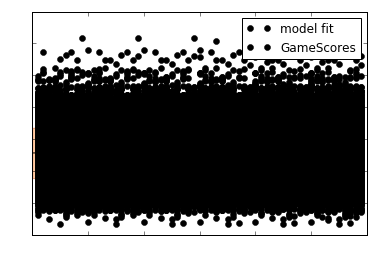

Dwyane Wade
611


[ 0.00872675]


[ 0.00327129]


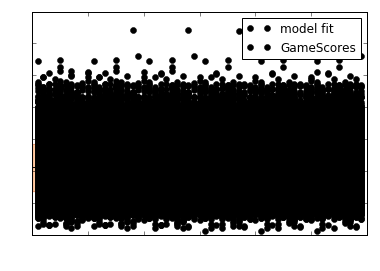

Shaquille O'Neal
23


[ 0.02294991]


[ 0.01284018]


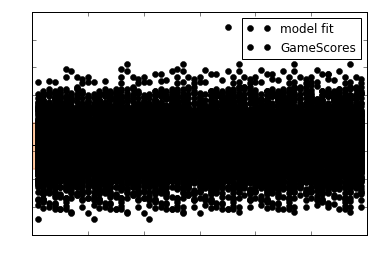

Shaquille O'Neal
55


[ 0.01013558]


[ 0.00941055]


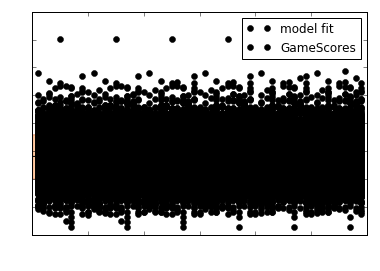

Carmelo Anthony
309


[ 0.00802699]


[ 0.00576207]


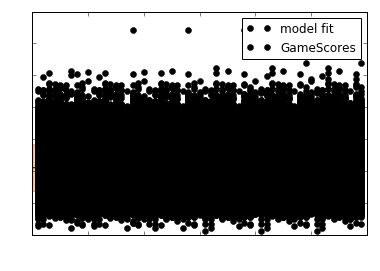

Chris Bosh
155


[ 0.00432767]


[ 0.0060185]


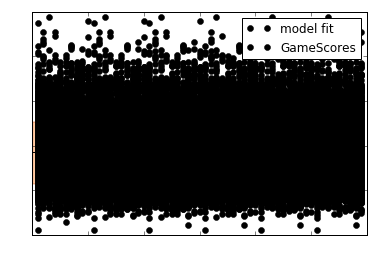

Kobe Bryant
65


[ 0.01954274]


[ 0.00840374]


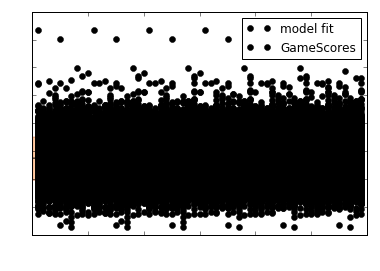

Michael Jordan
24


[ 0.02422085]


[ 0.01418719]


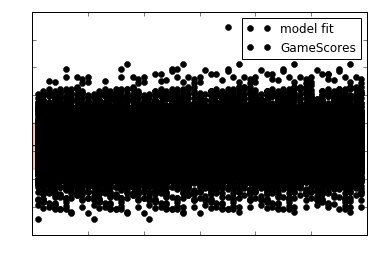

Michael Jordan
7


[ 0.01993223]


[ 0.01323375]


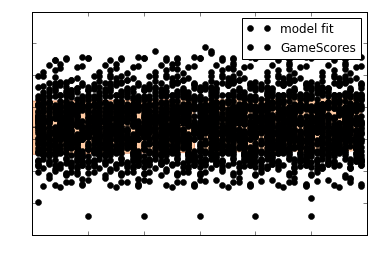

Michael Jordan
13


[ 0.01567969]


[ 0.00295502]


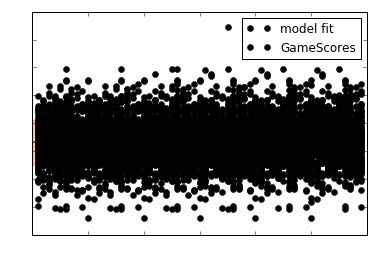

Steve Nash
131


[ 0.00299812]


[ 0.0082223]


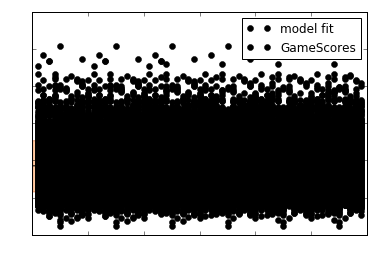

Steve Nash
131


[ 0.00299812]


[ 0.0082223]


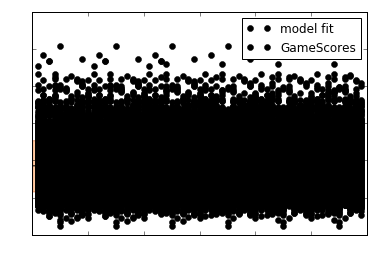

Tim Duncan
215


[ 0.00747118]


[-0.00045146]


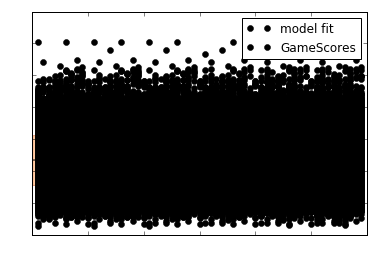

Amar'e Stoudemire
649


[ 0.00527468]


[ 0.00422683]


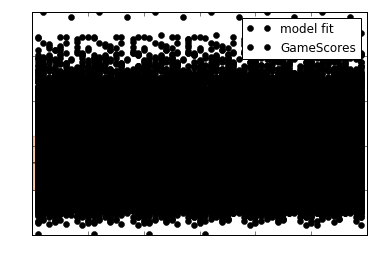

Mychal Thompson
455


[ 0.00284125]


[ 0.00687229]


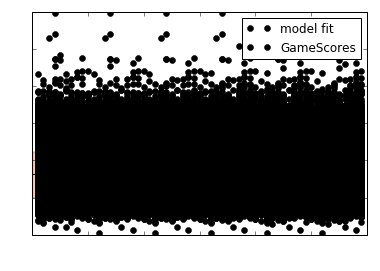

Tony Parker
358


[ 0.01082452]


[ 0.0068693]


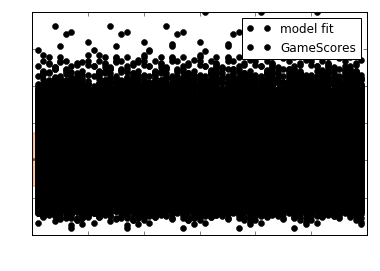

Lamar Odom
399


[ 0.00566676]


[ 0.00225642]


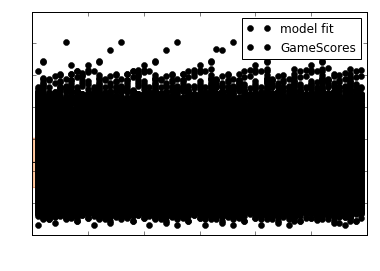

Dwyane Wade
611


[ 0.00872675]


[ 0.00327129]


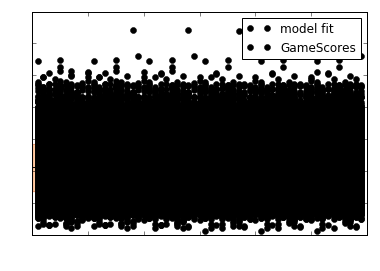

Kyrie Irving
538


[ 0.00846896]


[ 0.00559547]


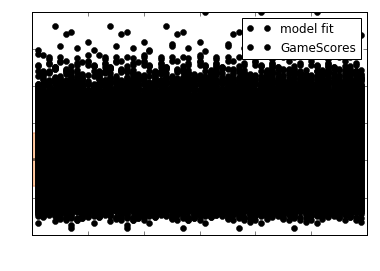

Dirk Nowitzki
450


[ 0.0081646]


[ 0.00618406]


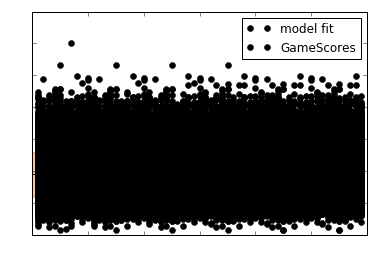

In [21]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# test: is month-month difference significantly different 
# from similar players' month-month variance?

#for each target player
for p_ind,player_info in enumerate(player_events):
    player_tofind=player_info[0]
    print player_tofind
    date_lifeevent=pd.to_datetime(player_info[1])

    #get season
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
        
    #load and clean up
    days_touse=30
    gamescores_matched = pd.read_csv(player_tofind+str(year_tofind)+'matches.csv')  
    gamescores_matched = gamescores_matched[['Date', 'GameScore', 'Player ID']]
    
    
    #for each player in the DB, take 2-month chunks and align as in player target DB
    GS_matched_pre = pd.DataFrame()
    GS_matched_post = pd.DataFrame()
    print len(gamescores_matched['Player ID'].unique())
    for pmatch_ind,pmatch_info in enumerate(gamescores_matched['Player ID'].unique()):
        gamescores_pmatch=gamescores_matched.loc[gamescores_matched['Player ID']==pmatch_info]
        if len(gamescores_pmatch)>82: #more than one season per player
            while len(gamescores_pmatch)>82:
                date1 = gamescores_pmatch['Date'].loc[gamescores_pmatch.index[0]]
                if pd.to_datetime(date1).month>=9:
                    season_end=pd.to_datetime(date1).year+1
                else:
                    season_end=pd.to_datetime(date1).year
                
                between_seasons = pd.to_datetime('07/01/'+str(season_end))
                seasondiff = pd.to_datetime(gamescores_pmatch['Date'])-pd.to_datetime(between_seasons)
                seasondiff=seasondiff.astype('timedelta64[D]')
                [GS_matched_pre,GS_matched_post]=align_games(gamescores_pmatch.loc[seasondiff <= 0],
                                                             days_touse, GS_matched_pre, GS_matched_post)
                gamescores_pmatch=gamescores_pmatch.loc[seasondiff>0] 
        elif (len(gamescores_pmatch)<82) & (len(gamescores_pmatch)>0):
            [GS_matched_pre,GS_matched_post]=align_games(gamescores_pmatch,days_touse,
                                                     GS_matched_pre,GS_matched_post)
    
    numdays_box=5
    fitandboxplot(GS_pre,GS_post,days_touse,numdays_box)
    
    GS_matched_pre.to_csv(player_tofind+str(year_tofind)+'matches_alignedpre.csv')    
    GS_matched_post.to_csv(player_tofind+str(year_tofind)+'matches_alignedpost.csv')    
    

In [37]:
# is there a difference between distribution of a player's GameScores before/after event
# and matched players' GameScores?

from scipy import stats

GS_target_pre = pd.read_csv('gamescores_preevent_actual.csv')
GS_target_post = pd.read_csv('gamescores_postevent_actual.csv')


for p_ind,player_info in enumerate(player_events):
    days_touse=30
    player_tofind=player_info[0]
    date_lifeevent=pd.to_datetime(player_info[1])

    #get season
    date_month=date_lifeevent.month
    if date_month > 9:
        year_tofind=date_lifeevent.year+1
    else:
        year_tofind=date_lifeevent.year    
        
    #load and clean up
    GS_matched_pre = pd.read_csv(player_tofind+str(year_tofind)+'matches_alignedpre.csv')  
    GS_matched_post = pd.read_csv(player_tofind+str(year_tofind)+'matches_alignedpost.csv')   

    GS_matched=pd.DataFrame()
    GS_matched=GS_matched.append(GS_matched_pre)
    GS_matched=GS_matched.append(GS_matched_post)
    GS_matched = GS_matched[['Date', 'GameScore', 'Player ID', 'Date Difference']]
    
    GS_target = pd.DataFrame()
    GS_1target_pre=GS_target_pre.loc[GS_target_pre['Player ID']==(player_info[3]+str(year_tofind))]
    GS_1target_post=GS_target_post.loc[GS_target_post['Player ID']==(player_info[3]+str(year_tofind))]
    
    GS_target = GS_target.append(GS_1target_pre)
    GS_target = GS_target.append(GS_1target_post)
    
    [z,p]=stats.ranksums(GS_matched_pre['GameScore'], GS_1target_pre['GameScore'])
    if p<0.05:
        print player_tofind+' pre'
        print [np.trunc(z*100)/100,np.trunc(p*1000)/1000]


    [z,p]=stats.ranksums(GS_matched_post['GameScore'], GS_1target_post['GameScore'])
    if p<0.05:
        print player_tofind+' post'
        print [np.trunc(z*100)/100,np.trunc(p*1000)/1000]

    # for days in range(-days_touse+1,days_touse):
    #     df_matched=GS_matched.loc[GS_matched['Date Difference']==days]
    #     df_target
    #     expval=np.mean(df_matched['GameScores'])


Dwyane Wade pre
[-4.8200000000000003, 0.0]
Carmelo Anthony pre
[-3.2799999999999998, 0.001]
Carmelo Anthony post
[-2.6499999999999999, 0.0070000000000000001]
Chris Bosh pre
[-2.0600000000000001, 0.037999999999999999]


Kobe Bryant pre
[-2.7999999999999998, 0.0050000000000000001]
Kobe Bryant post
[-3.2000000000000002, 0.001]
Michael Jordan pre
[-2.0499999999999998, 0.040000000000000001]
Michael Jordan post
[-2.0699999999999998, 0.036999999999999998]
Steve Nash pre
[-4.0899999999999999, 0.0]
Steve Nash post
[-5.8399999999999999, 0.0]


Amar'e Stoudemire pre
[-3.0299999999999998, 0.002]
Amar'e Stoudemire post
[-2.1400000000000001, 0.031]
Mychal Thompson pre
[-2.7000000000000002, 0.0060000000000000001]


Tony Parker pre
[-2.25, 0.023]


Dwyane Wade pre
[-4.8200000000000003, 0.0]
Kyrie Irving pre
[-2.1200000000000001, 0.033000000000000002]


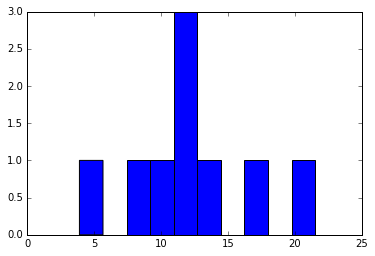